In [1]:
import tensorflow as tf
import torch
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import os
from os import path
import shutil


dtype = torch.float
device = torch.device("cpu")

In [2]:
tf.__version__

'2.8.0'

In [3]:

#src = "chest_xray/train/PNEUMONIA"
#dst1 = "chest_xray/train/PNEUMONIA_BACTERIAL"
#dst2 = "chest_xray/train/PNEUMONIA_VIRUS"
#files_bacteria = [i for i in os.listdir(src) if "bacteria" in i and path.isfile(path.join(src, i))]
#files_virus = [i for i in os.listdir(src) if "virus" in i and path.isfile(path.join(src, i))]


#for f in files_bacteria:
 #   shutil.move(path.join(src, f), dst1)

#for f in files_virus:
 #   shutil.move(path.join(src, f), dst2)


In [60]:
#src = "chest_xray/test/PNEUMONIA"
#dst1 = "chest_xray/test/PNEUMONIA_BACTERIAL"
#dst2 = "chest_xray/test/PNEUMONIA_VIRUS"
#files_bacteria = [i for i in os.listdir(src) if "bacteria" in i and path.isfile(path.join(src, i))]
#files_virus = [i for i in os.listdir(src) if "virus" in i and path.isfile(path.join(src, i))]


#for f in files_bacteria:
 #   shutil.move(path.join(src, f), dst1)

#for f in files_virus:
 #   shutil.move(path.join(src, f), dst2)

In [5]:
data_dir = './chest_xray/train'
img_height = 180
img_width = 180
batchSize = 32

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                       validation_split=0.2,
                                                       subset="training",
                                                       seed=123,
                                                       image_size=(img_height,img_width),
                                                       batch_size=batchSize
                                                      )


Found 5232 files belonging to 3 classes.
Using 4186 files for training.


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batchSize)

Found 5232 files belonging to 3 classes.
Using 1046 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)

['NORMAL', 'PNEUMONIA_BACTERIAL', 'PNEUMONIA_VIRUS']


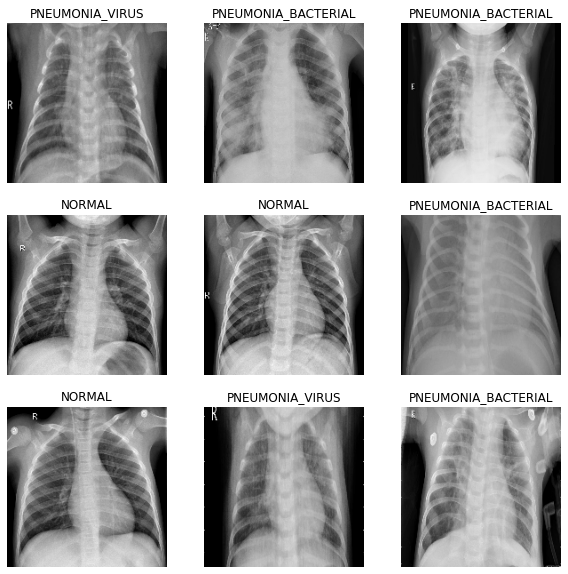

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
#normalization_layer = layers.Rescaling(1./255)

In [12]:
#train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))#
#val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
#image_batch, labels_batch = next(iter(train_ds))
#first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
#print(np.min(first_image), np.max(first_image))

In [49]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",input_shape=(img_height, img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [54]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Conv2D(48, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Conv2D(92, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation ='softmax')
])

In [55]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [56]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_12 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 rescaling_10 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_29 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 batch_normalization_29 (Bat  (None, 90, 90, 16)       64        
 chNormalization)                                                
                                                                 
 conv2d_30 (Conv2D)          (None, 90, 90, 48)      

In [57]:
with tf.device('/cpu:0'):    
    epochs=15
    history = model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=epochs
    )

Epoch 1/15
131/131 [==============================] - 54s 408ms/step - loss: 1.0948 - accuracy: 0.6591 - val_loss: 7.7637 - val_accuracy: 0.5019
Epoch 2/15
131/131 [==============================] - 57s 433ms/step - loss: 0.6158 - accuracy: 0.7205 - val_loss: 2.9624 - val_accuracy: 0.5115
Epoch 3/15
131/131 [==============================] - 56s 424ms/step - loss: 0.5761 - accuracy: 0.7496 - val_loss: 0.6361 - val_accuracy: 0.7132
Epoch 4/15
131/131 [==============================] - 56s 426ms/step - loss: 0.5618 - accuracy: 0.7549 - val_loss: 1.3063 - val_accuracy: 0.5191
Epoch 5/15
131/131 [==============================] - 56s 429ms/step - loss: 0.5399 - accuracy: 0.7714 - val_loss: 0.5761 - val_accuracy: 0.7562
Epoch 6/15
131/131 [==============================] - 56s 429ms/step - loss: 0.5226 - accuracy: 0.7764 - val_loss: 0.7326 - val_accuracy: 0.7237
Epoch 7/15
131/131 [==============================] - 56s 430ms/step - loss: 0.5199 - accuracy: 0.7797 - val_loss: 0.6874 - val_ac

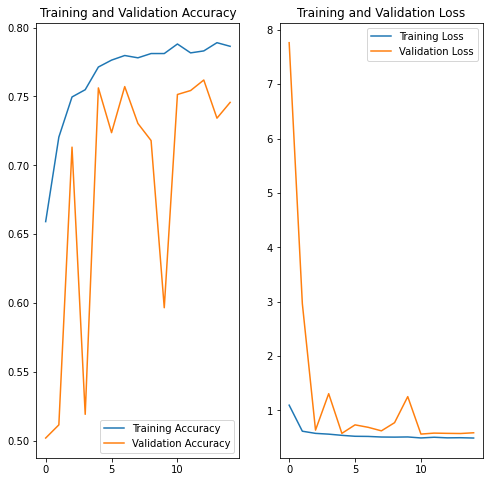

In [58]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [69]:
test_normal_path = "chest_xray/train/NORMAL/"
test_bacterial_path= "chest_xray/test/PNEUMONIA_BACTERIAL"
test_virus_path= "chest_xray/test/PNEUMONIA_VIRUS"

test_files_bacteria = [i for i in os.listdir(test_bacterial_path) if "bacteria" in i and path.isfile(path.join(test_bacterial_path, i))]
test_files_virus = [i for i in os.listdir(test_virus_path) if "virus" in i and path.isfile(path.join(test_virus_path, i))]
test_files_normal = [i for i in os.listdir(test_normal_path) if "NORMAL" in i and path.isfile(path.join(test_normal_path, i))]
img = tf.keras.utils.load_img(
    path.join(test_normal_path, test_files_normal[0]), target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch



In [74]:
count = 0
for index in range(len(test_files_normal)):
    img = tf.keras.utils.load_img(
    path.join(test_normal_path, test_files_normal[index]), target_size=(img_height, img_width))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    if class_names[np.argmax(score)] == "NORMAL":
        count+=1

        
print("Accuracy for normal = ", count/len(test_files_normal) *100, "%")


Accuracy for normal =  85.77127659574468 %


In [78]:
count = 0
diagnosed = 0
for index in range(len(test_files_bacteria)):
    img = tf.keras.utils.load_img(
    path.join(test_normal_path, test_files_normal[index]), target_size=(img_height, img_width))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    if class_names[np.argmax(score)] == "PNEUMONIA_BACTERIAL":
        count+=1
    if class_names[np.argmax(score)] == "PNEUMONIA_BACTERIAL" or class_names[np.argmax(score)] == "PNEUMONIA_VIRUS":
        diagnosed+=1
    

print("Accuracy for bacterial pneumonia = ", count/len(test_files_bacteria) *100, "%")
print("Accuracy for pneumonia = ", diagnosed/len(test_files_bacteria) *100, "%")

Accuracy for bacterial pneumonia =  4.545454545454546 %
Accuracy for pneumonia =  10.743801652892563 %


In [79]:
count = 0
diagnosed = 0
for index in range(len(test_files_virus)):
    img = tf.keras.utils.load_img(
    path.join(test_normal_path, test_files_normal[index]), target_size=(img_height, img_width))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    if class_names[np.argmax(score)] == "PNEUMONIA_VIRUS":
        count+=1
    if class_names[np.argmax(score)] == "PNEUMONIA_BACTERIAL" or class_names[np.argmax(score)] == "PNEUMONIA_VIRUS":
        diagnosed+=1
print("Accuracy for viral pneumonia = ", count/len(test_files_virus) *100, "%")
print("Accuracy for  pneumonia = ", diagnosed/len(test_files_virus) *100, "%")

Accuracy for viral pneumonia =  7.4324324324324325 %
Accuracy for  pneumonia =  12.162162162162163 %
